In [1]:
# dependencies and libraries
import sqlite3
import io
import pandas as pd
import numpy as np
from collections import defaultdict
from pathlib import Path
from decimal import Decimal
from scipy.stats import wasserstein_distance, entropy
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams["figure.figsize"] = (10, 8)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

In [2]:
conn = sqlite3.connect("SeeDb.db")
cursor = conn.cursor()
agg_funcs = ['avg', 'sum', 'count', 'min', 'max']
dimensions = ['sex', 'work_class', 'education', 'marital_status', 'occupation', 'relationship', 
                  'race', 'native_country', 'class']
measures = ['age','fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
epsilon = Decimal(1e-8)

In [4]:
#this cell has the functions definitions responsible to create, fill and query the database
#run this cell once whenever the notebook is disconnected to create the database and fill it locally

def create_fill_database(): 
  # Drop table if it exists
  cursor.execute('''DROP TABLE IF EXISTS census''')
  # Create table
  cursor.execute('''CREATE TABLE census
                (age int, work_class text, fnlwgt int, education text, education_num int, marital_status text, occupation text, relationship text, 
                race text, sex text, capital_gain int, capital_loss int, hours_per_week int, native_country text, class text)''')

  #fill the database
  df = pd.DataFrame(pd.read_csv('adultdata.csv'))
  for row in df.itertuples():
      cursor.execute('''
                  INSERT INTO census (age, work_class, fnlwgt, education, education_num, marital_status, occupation, relationship, 
                  race, sex, capital_gain, capital_loss, hours_per_week, native_country, class)
                  VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)
                  ''',
                  (row.AGE, row.WORK_CLASS, row.FNLWGT, row.EDUCATION, row.EDUCATION_NUM, row.MARITAL_STATUS, row.OCCUPATION, row.RELATIONSHIP, 
                  row.RACE, row.SEX, row.CAPITAL_GAIN, row.CAPITAL_LOSS, row.HOURS_PER_WEEK, row.NATIVE_COUNTRY, row.CLASS)
                  )   
  conn.commit()
  #conn.close()
  
create_fill_database()


## Phase-based Execution Framework:

In [5]:
def execute_query(query):
  """Returns a dataframe object with all the resulting records
  Arguments:
    query: The query to execute"""
  records_df = pd.read_sql_query(query, conn)
  return records_df


def partition_DB(n):
  """Returns a list of each partition starting point
  Arguments:
    n: number of partitions
    """
  records_count = execute_query("select count(*) from census").iloc[0]
  
  partition_size = int(records_count/n)
  range_start = []
  for i in range(n):
    range_start.append(i*partition_size)
  return range_start


def run_query_on_partition(query, start, end = -1):
  """Execute query on dataset partition
  Arguments:
    query: query to execute
    start: start of the dataset partition (not inclusive)
    end: end of the dataset partition (inclusive) (default -1 for the last partition)
  Returns:
    Dataframe containing result of executing the query on the dataset partition 
  """
  part1 = query
  part2 = ""
  idx = query.lower().find("group by")
  if idx != -1:
    part1 = query[:idx]
    part2 = query[idx:]

  if "where" in part1.lower():
    part1 += " AND rowid > " + str(start)
  else:
    part1 += " where rowid > " + str(start)
  
  if end != -1:
    part1 += " AND rowid <= " + str(end)
  
  return execute_query(part1 + " " + part2)

In [6]:
def get_all_views():
  """Returns all possible views which is m*a*f views"""
  views = []
  for f in agg_funcs:
      for a in dimensions:
          for m in measures:
              views.append((a, m, f))

  print('Total number of views: {}'.format(len(views)))
  return views

## Sharing-based Optimizations:

Implementation of First-Fit Decreasing Algorithm:

In [7]:
import operator
class Bin:
    def __init__(self, c):
        self.items = []
        self.remaining_cap = c
    
    def add(self, dimension, weight):
        self.items.append(dimension)
        self.remaining_cap -= weight

    def get_dimensions(self):
        return self.items

    def get_cap(self):
        return self.remaining_cap

def first_fit(dimensions, c):
    bins = []
    # add first bin
    bins.append(Bin(c))
    for dimension, weight in dimensions:
        need_new_bin = True
        for bin in bins:
            if bin.get_cap() >= weight:
                bin.add(dimension, weight)
                need_new_bin = False
                break
        if need_new_bin:
            bins.append(Bin(c))
            bins[-1].add(dimension, weight)

    return [b.get_dimensions() for b in bins]

def first_fit_dec(dimensions, c):
    sorted_dims = sorted(dimensions.items(), key=operator.itemgetter(1), reverse=True)
    return (first_fit(sorted_dims, c))

def get_distinct_dimension_counts_log10():
    count_str = []
    for d in dimensions:
        count_str.append('count(distinct {0}) as {0}'.format(d))
    count_str=", ".join(count_str)
    query = "SELECT {} FROM census".format(count_str)
    output = execute_query(query)
    log_values = np.log10(np.array(output)[0]) # because the output is [[2, 7, 16, 7, 14, 6, 5, 41, 2]]
    column_names = output.columns 
    return dict(zip(column_names, log_values))

dist_dimension_count_log10s = get_distinct_dimension_counts_log10()
print(dist_dimension_count_log10s)

first_fit_dec(dist_dimension_count_log10s, np.log10(10000))

{'sex': 0.3010299956639812, 'work_class': 0.8450980400142568, 'education': 1.2041199826559248, 'marital_status': 0.8450980400142568, 'occupation': 1.146128035678238, 'relationship': 0.7781512503836436, 'race': 0.6989700043360189, 'native_country': 1.6127838567197355, 'class': 0.3010299956639812}


[['native_country', 'education', 'occupation'],
 ['work_class', 'marital_status', 'relationship', 'race', 'sex', 'class']]

In [19]:
def get_combined_queries():
    queries = []
    dimensions_str = ', '.join(dimensions)
    measures_str = []
    for f in agg_funcs:
        for m in measures:
            measures_str.append('{0}({1}) as {0}_{1}'.format(f, m))
    measures_str = ', '.join(measures_str)
    
    #group_by_str = dimensions_str
    
    ref_target_string = """ ,CASE WHEN marital_status in ('Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent') THEN 'Married' ELSE 'Unmarried' END Grouped_Marital_Status """
    dimensions_str += ref_target_string
    
    #get the best combination of group by attributes to fit in memory
    dist_dimension_count_log10s = get_distinct_dimension_counts_log10()
    group_by_lists = first_fit_dec(dist_dimension_count_log10s, np.log10(10000))
    for group in group_by_lists:
        group_by_str = ', '.join(group)
        group_by_str += ", Grouped_Marital_Status"
        queries.append('select {}, {} from census group by {};'.format(dimensions_str, measures_str, group_by_str))

        
    #queries.append('select {}, {} from census group by {};'.format(dimensions_str, measures_str, group_by_str))
    #where_strs = ["marital_status in ('Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent')", "marital_status in ('Never-married', 'Widowed', 'Divorced', 'Separated')"]
    # for i in range(len(dimensions) - 1):
    #     where_str += "not trim({})='?' and ".format(dimensions[i])
    # where_str += " not trim({})='?'".format(dimensions[-1])
#     for where_str in where_strs:
#         queries.append('select {}, {} from census where {} group by {};'.format(dimensions_str, measures_str, where_str, group_by_str))
    return queries

In [22]:
combined_queries = get_combined_queries()
results = []

#partition the database into n partitions
n = 10
partitions_start = partition_DB(n)
for i in range(n):
  for query in combined_queries:
    partition_end = -1 if (i == n-1) else partitions_start[i+1]
    result_df = run_query_on_partition(query, partitions_start[i], partition_end)
    results.append(result_df)

display(results)
    
# for q in queries:
#     cur.execute(q)
#     results.append(pd.DataFrame(cur.fetchall()))
#     results[-1].columns = [desc[0] for desc in cur.description]


[        sex        work_class     education         marital_status  \
 0      Male           Private     Bachelors  Married-spouse-absent   
 1      Male  Self-emp-not-inc       HS-grad     Married-civ-spouse   
 2    Female           Private           9th               Divorced   
 3      Male           Private     Assoc-voc     Married-civ-spouse   
 4    Female           Private     Assoc-voc     Married-civ-spouse   
 ..      ...               ...           ...                    ...   
 465    Male           Private  Some-college     Married-civ-spouse   
 466    Male           Private  Some-college          Never-married   
 467    Male         Local-gov     Bachelors          Never-married   
 468    Male           Private  Some-college          Never-married   
 469    Male           Private       HS-grad     Married-civ-spouse   
 
            occupation    relationship                race native_country  \
 0      Prof-specialty   Not-in-family  Asian-Pac-Islander       Camb

Calculate utilities for combined GROUP-BYs:

In [ ]:
def kl_divergence(target_agg_vals, ref_agg_vals):
    # normalize
    t_sum = sum(target_agg_vals)
    r_sum = sum(ref_agg_vals)
    t_norm = [i/t_sum for i in target_agg_vals]
    r_norm = [i/r_sum for i in ref_agg_vals]
    print(t_norm)
    # calculate divergence
    return entropy(t_norm, r_norm)


In [ ]:
def calculate_utility(target_agg_vals, ref_agg_vals):
    # Earth Mover's Distance
    # return wasserstein_distance(target_agg_vals, ref_agg_vals)
    # KL Divergence
    return kl_divergence(target_agg_vals, ref_agg_vals)

def get_target_and_ref_aggregated_fms(aggregated_fms):
    # Now we make sure the same values for dimension attributes exist in the mapping for both target and reference. 
    #Then, we can return the list of aggregate function values corresponding to those dimension values to be used for calculating utility.

    target_fms = aggregated_fms[0]
    ref_fms = aggregated_fms[1]
    dim_agg_pairs = defaultdict(list)
    target_agg_vals = []
    ref_agg_vals = []

    for dimension_val, agg_val in target_fms.items():
        if agg_val == 0:
            temp = epsilon
        else:
            temp = agg_val
        dim_agg_pairs[dimension_val].append(temp)

    for dimension_val, agg_val in ref_fms.items():
        if dimension_val not in dim_agg_pairs: # dim_val in ref but not in target
            dim_agg_pairs[dimension_val].append(epsilon)
        
        if agg_val == 0:
            temp = epsilon
        else:
            temp = agg_val
        dim_agg_pairs[dimension_val].append(temp)

    for dim_val, agg_vals in dim_agg_pairs.items():
        if len(agg_vals) < 2: # dim_val in target but not in ref
            dim_agg_pairs[dim_val].append(epsilon)
        
    for agg_vals in dim_agg_pairs.values():
        target_agg_vals.append(agg_vals[0])
        ref_agg_vals.append(agg_vals[1])

    return target_agg_vals, ref_agg_vals

def calculate_dimension_avg(fm_values, count_ms):
    agg_val_sum = 0
    count_sum = 0
    for fm, count in zip(fm_values, count_ms):
        count_sum += count
        agg_val_sum += fm * count
    if count_sum != 0:
        return agg_val_sum/count_sum
    else:
        return epsilon

def calculate_aggregate_value(dim_val, fm_values, agg_func, result, m, a):
    if agg_func == 'avg':
        count_ms=list(result[result[a] == dim_val]["count_{}".format(m)]) # count(m) for the corresponding row
        return calculate_dimension_avg(count_ms, fm_values)
    elif agg_func == 'min':
        return min(fm_values)
    elif agg_func == 'max':
        return max(fm_values)
    elif agg_func == 'sum':
        return sum(fm_values)
    elif agg_func == 'count':
        return sum(fm_values)
    else:
        raise ValueError("Aggregate function cannot be {} for dimension value {}!".format(agg_func, dim_val))


def calc_utilities(results):
    utilities = {}
    aggregated_fms = [defaultdict(list), defaultdict(list)]
    for (a, m, f) in get_all_views():
        for i in range(len(results)): # for target and reference results
            result = results[i]
            for dim_val in result[a].unique(): # for every value of a dimension
                # if dim_val == '?':
                #     continue
                fm_values=list(result[result[a] == dim_val]["{}_{}".format(f,m)]) # get all of corresponding f(m) values
                aggregated_fms[i][dim_val] = calculate_aggregate_value(dim_val, fm_values, f, result, m, a)
                target_agg_vals, ref_agg_vals = get_target_and_ref_aggregated_fms(aggregated_fms)
        utilities[(a, m, f)] = (calculate_utility(target_agg_vals, ref_agg_vals))
    return utilities

view_utilities = calc_utilities(results[0:2]) # we should change here Hadeel
view_utilities

Total number of views: 270


{('class', 'age', 'avg'): 2.160687729905148,
 ('class', 'age', 'count'): 5.698299060979368,
 ('class', 'age', 'max'): 2.704969089857286,
 ('class', 'age', 'min'): 3.8318569204064414,
 ('class', 'age', 'sum'): 6.519405439739477,
 ('class', 'capital_gain', 'avg'): 2.1511133730708885,
 ('class', 'capital_gain', 'count'): 5.698299060979368,
 ('class', 'capital_gain', 'max'): 0.13830570288829985,
 ('class', 'capital_gain', 'min'): 3.9121238603003277,
 ('class', 'capital_gain', 'sum'): 1.4754317434023967,
 ('class', 'capital_loss', 'avg'): 2.158011485934539,
 ('class', 'capital_loss', 'count'): 5.698299060979368,
 ('class', 'capital_loss', 'max'): 1.4989259773593173,
 ('class', 'capital_loss', 'min'): 3.9121238603003277,
 ('class', 'capital_loss', 'sum'): 5.500747493833211,
 ('class', 'education_num', 'avg'): 2.1602288609068485,
 ('class', 'education_num', 'count'): 5.698299060979368,
 ('class', 'education_num', 'max'): 2.769578483931764,
 ('class', 'education_num', 'min'): 3.906791783360614

In [ ]:
k = 10

def get_top_k_views(view_utilities, k):
    return sorted(view_utilities.items(), key= lambda item: item[1], reverse=True)[:k]


get_top_k_views(view_utilities, k)

[(('marital_status', 'fnlwgt', 'sum'), 37.7958485905924),
 (('relationship', 'fnlwgt', 'sum'), 35.85922925537636),
 (('marital_status', 'fnlwgt', 'max'), 32.269467639637604),
 (('marital_status', 'capital_gain', 'sum'), 29.65112484280034),
 (('marital_status', 'capital_gain', 'max'), 29.465731147876216),
 (('relationship', 'capital_gain', 'sum'), 28.369322042544738),
 (('marital_status', 'fnlwgt', 'min'), 26.610751175325454),
 (('relationship', 'capital_gain', 'max'), 25.57869033503214),
 (('native_country', 'capital_gain', 'max'), 17.32342551559357),
 (('native_country', 'capital_loss', 'max'), 17.0370549301097)]

### Visualizing top k queries:

In [ ]:
### TODO implement function to visualize the top k queries

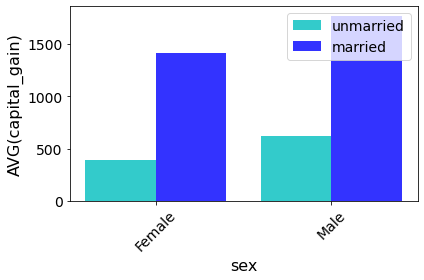

CPU times: user 273 ms, sys: 124 ms, total: 396 ms
Wall time: 335 ms


In [ ]:
%%time

#please use the execute_query function to execute any query on the database, 
#it returns a dataframe with the result
query = """drop view if exists married; create view married as select * from census where marital_status in ('Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent');
           drop view if exists unmarried; create view unmarried as select * from census where marital_status in ('Never-married', 'Widowed','Divorced', 'Separated');"""
cur.executescript(query)
conn.commit()

# capital gain group-by sex for the target data
query = "SELECT sex, avg(capital_gain) FROM married GROUP BY sex;"
cur.execute(query)
target_rows = cur.fetchall()

query = "SELECT sex, avg(capital_gain) FROM unmarried GROUP BY sex;"
cur.execute(query)
ref_rows = cur.fetchall()

def visualize(target_data, ref_data, view_tuple):
    n_groups = len(target_data)
    group_by, measurement, agg_func = view_tuple

    target_val = target_data.values()
    ref_val = ref_data.values()

    # create plot
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.4
    opacity = 0.8

    rects1 = plt.bar(index, ref_val, bar_width, alpha=opacity, color='c', label='unmarried')
    rects2 = plt.bar(index + bar_width, target_val, bar_width, alpha=opacity, color='b', label='married')

    plt.xlabel('{}'.format(group_by), fontsize = 16)
    plt.ylabel('{}({})'.format(agg_func, measurement), fontsize = 16)
    plt.xticks(index + 0.5 * bar_width, ref_data.keys(), rotation=45)
    plt.legend(fontsize=14)

    plt.tight_layout()
    plt.show()

view_tuple = ('sex', 'capital_gain', 'AVG')
visualize(dict(target_rows), dict(ref_rows), view_tuple)

## **Pruning based optimization**

In [ ]:
import heapq
#pruning based optimization function

def get_top_k_views(optimized_queries, k, referenceDB_query, targetDB_query):
  views = []
  
  #partition the database into n partitions
  n = 10
  #partitions_start_target = partition_DB(n,0)
  #partitions_start_reference = partition_DB(n,1)
  partitions_start = partition_DB(n)
  current_mean = defaultdict(int)
  top_k = []
  #start running the optimized queries to the database partiotions one by one and apply the pruning based optimization to get rid of views with low utility
  for i in range(n):
    for query in optimized_queries:
      partition_end = -1 if (i == n-1) else partitions_start[i+1]
      #partition_end_reference = -1 if (i == len(n)-1) else partitions_start_reference[i+1]

      #result of executing query on oe partition
      result_df = run_query_on_partition(query, partitions_start[i], partition_end)
      #result_df_reference = run_query_on_partition(query, partitions_start_reference[i], partition_end_reference)
      utility_score = calculate_utility(result_df_target, result_df_reference)
      current_mean[query] = (current_mean[query]*i + utility_score)/(i+1)
      upper

  #return top k views
  return views;


In [ ]:
def recommend_views(userQuery, k, referenceDB, targetDB):
    optimized_queries = QueryRewrite(userQuery)
    top_k_views = get_top_k_views(optimized_queries, k, referenceDB, targetDB)
    return top_k_views;


In [ ]:
from IPython.core.display import Math
def Hoeffding_Serfling_Error(delta,m,N):
  return Math.sqrt(    (1-(m-1)/N) *  (  2*Math.log(Math.log(m))  +  Math.log(Math.PI**2/(3*delta))  )/(2*m))

In [ ]:
# %%time

# n_splits = 10
# split_path = Path('/content/census.splits')
# split_path.mkdir(parents=True, exist_ok=True)

# df = pd.DataFrame(pd.read_csv('/content/adultdata.csv'))
# df.columns = [i.replace('-', '_') for i in df.columns]

# df_split= np.array_split(df, n_splits)

# for i in range(len(df_split)):
#     df_split[i].to_csv(Path(split_path / "census.split_{}.csv".format(i)), encoding='utf-8', index=False)

# !zip -r /content/census.splits.zip /content/census.splits

In [ ]:
# for i in range(n_splits):
#     cur.executescript('''drop table if exists split_{};
#                         create table split_{}
#                         (age int, work_class text, fnlwgt int, education text, education_num int, marital_status text, occupation text, relationship text, 
#                         race text, sex text, capital_gain int, capital_loss int, hours_per_week int, native_country text, class text)'''.format(i, i))
    
#     # change this to psql
#     df = pd.DataFrame(pd.read_csv('/content/census.splits/census.split_{}.csv'.format(i)))
#     for row in df.itertuples():
#         cur.execute('''
#                   INSERT INTO split_{} (age, work_class, fnlwgt, education, education_num, marital_status, occupation, relationship, 
#                   race, sex, capital_gain, capital_loss, hours_per_week, native_country, class)
#                   VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)
#                   '''.format(i),
#                   (row.AGE, row.WORK_CLASS, row.FNLWGT, row.EDUCATION, row.EDUCATION_NUM, row.MARITAL_STATUS, row.OCCUPATION, row.RELATIONSHIP, 
#                   row.RACE, row.SEX, row.CAPITAL_GAIN, row.CAPITAL_LOSS, row.HOURS_PER_WEEK, row.NATIVE_COUNTRY, row.CLASS)
#                   )   

# conn.commit()
# census_view_query = 'drop view if exists census_view; create view census_view as select * from split_0'
# for i in range(1, n_splits):
#     census_view_query += ' union select * from split_{}'.format(i)
# census_view_query += ';'
# cur.executescript(census_view_query)
# conn.commit()

In [ ]:
# n_phases = n_splits
# for i in range(n_phases):
#     query = """drop view if exists split_{0}_married; create view split_{0}_married as select * from split_{0} where marital_status in ('Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent','Separated');
#            drop view if exists split_{0}_unmarried; create view split_{0}_unmarried as select * from split_{0} where marital_status in ('Never-married', 'Widowed','Divorced');""".format(i)
#     cur.executescript(query)
#     conn.commit()